In [1]:
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as widgets
import scipy

%matplotlib inline

# Settings for the figures
plt.style.use(plt.style.available[20])
plt.style.use("https://github.com/comp-neural-circuits/intro-to-comp-neuro/raw/dev/plots_style.txt")

In [43]:
class LIFNeuron(object):
    """A LIF neuron with the possibility to add AMPA inputs 
    the methods allow to run the simulation for a certain number of steps while keeping track of the membrane voltage
    and plot the results of the run
    """
    def __init__(self, 
                 c_m = 1, r_m = 10, v_reset = -75, refrac_time = 10, v_th = -54, e_l = -75, i_e = 0, dt = 0.05,
                 n_gaba_inputs = 0, n_ampa_inputs = 0, # CHANGE: we now need to specify how many inputs the neuron receives
                 g_ampa = 0, g_gaba = 0, # CHANGE: Here we now can also provide an array og length n_xxxx_inputs to 
                                         # allow different synaptic strenghts
                 allow_spiking = True,
                ):
        '''This function is executed when we create an object from that class'''
        super(LIFNeuron, self).__init__()

        ### assign the attributes of the class
        self.r_m = r_m # membrane resistance in M Ohm/cm**2
        self.tau_m = self.r_m * c_m  # membrane time constant
        self.e_l = e_l # leak reversal potential

        
        self.v_reset = v_reset # reset voltage after a spike
        self.v_th = v_th # threshold voltage
        self.i_e = i_e # Input current


        self.v = self.e_l # starting voltage value for the simulation
        self.dt = dt # simulation timestep    

        
        ''' refractory period '''
        self.refrac_time = refrac_time # in ms
        self.refrac_tracker = 0
        ''' refractory period '''
        
        self.v_list = [self.v]
        self.t_list = [0]
        self.i_e_list = [self.i_e]
        
        self.spike_times = []
        self.allow_spiking = allow_spiking
        
        
        ### Initiate synaptic paramters
        # CHANGE: Here we now need arrays instead of the simple single instances we had before.
        self.ps_ampa = np.zeros(n_ampa_inputs) # when starting the simulations the channels should be closed
        self.ampa_input = np.zeros(n_ampa_inputs).astype(bool) # and there is no input
        self.g_ampa = np.ones(n_ampa_inputs)*g_ampa # strength of synaptic input
        
        self.e_ampa = 0 # reversal potential of the AMPA channel
        self.tau_ampa = 5.26 # in ms, AMPA is rather fast
        
        self.ps_gaba = np.zeros(n_gaba_inputs) # when starting the simulations the channels should be closed
        self.gaba_input = np.zeros(n_gaba_inputs).astype(bool) # and there is no input
        self.g_gaba = np.ones(n_gaba_inputs)*g_gaba # strength of synaptic input
        
        self.e_gaba = -80 # reversal potential of the GABA channel
        self.tau_gaba = 8 # in ms
        


    def timestep(self):
        '''
            This function performs an update step of the membrane voltage evolution
            we use forward euler
        '''
        
        ### Time evolution of the synaptic input
        
        # first the decay # NO CHANGE - this actually remains the same, only now with arrays for all inputs
        dps_ampa_dt = -self.ps_ampa / (self.tau_ampa) # The channels close with an exponential decay
        self.ps_ampa += dps_ampa_dt * self.dt

        # then we set the open channels to 1
        self.ps_ampa[self.ampa_input == True] = 1 # if there is a spike in this time step, the channels open
        self.ampa_input[:] = False # remove the input 
        
        
        # first the decay
        dps_gaba_dt = -self.ps_gaba / (self.tau_gaba) # The channels close with an exponential decay
        self.ps_gaba += dps_gaba_dt * self.dt
        
        # then we set the open channels to 1
        self.ps_gaba[self.gaba_input == True] = 1 # if there is a spike in this time step, the channels open
        self.gaba_input[:] = False # remove the input
        
        
            
        ### Time evolution of the membrane potential
        current_time = self.t_list[-1] + self.dt
        
        
        ''' refractory period '''
        if self.refrac_tracker > 0:
            self.refrac_tracker -= self.dt
            
        
        else:
            
            # CHANGE: Now we need to sum over all inputs (and only if there are any, otherwise there is an error)
            if self.ps_ampa.size != 0:
                i_ampa = np.sum(self.g_ampa*self.ps_ampa*(self.e_ampa-self.v)) # ps_ampa is an array, therefore we need the sum
            else:
                i_ampa = 0
            
            if self.ps_gaba.size != 0:
                i_gaba = np.sum(self.g_gaba*self.ps_gaba*(self.e_gaba-self.v)) # ps_gaba is an array 
            else:
                i_gaba = 0



            ### Time evolution of the membrane potential
            if self.v <= self.v_th or not self.allow_spiking:
                dv_dt = (-self.v + self.e_l + self.r_m * self.i_e + self.r_m*i_ampa + self.r_m*i_gaba )/self.tau_m
                self.v += dv_dt * self.dt
            else:
                # here we implement a spiking behavior (mainly just for the look)
                if self.v != 40:
                    self.v = 40
                else:
                    self.v = self.v_reset
                    self.refrac_tracker = self.refrac_time
                    self.spike_times.append(current_time)
                
                
                
        self.v_list.append(self.v)
        self.t_list.append(current_time) 
        self.i_e_list.append(self.i_e)


    def run_simulation(self, time_steps = 100, 
                       i_e_array = np.array([]), # we can provide an array for the input current. 
                 # If none is provided or the current timestep is bigger than the array length, self.i_e is taken
                       ampa_inputs = [],
                       gaba_inputs = [],
                      ):
        '''
            Function to run the simulation for a fixed number of time steps (time_steps)
        '''
        
        # CHANGE - to make the scanning for inputs more efficiently, we first put all input times into one list
        flat_list_ampa = [int(item/self.dt) for sublist in ampa_inputs for item in sublist]
        flat_list_gaba = [int(item/self.dt) for sublist in gaba_inputs for item in sublist]
        
        
        for ii in range(time_steps):
            # we check whether we can take the input current (i_e) value from the list of inputs
            if len(i_e_array) > ii:
                self.i_e = i_e_array[ii]
                
            # we can check whether our current timestep is in the list of inputs we provide
            # CHANGE: we now first check whether there is ANY input at this time, then we iterate through the list to 
            # check which synapse is active
            if ii in flat_list_ampa: # this ensures that we only loop through the inputs, if there is a hit
                for nn, inputs in enumerate(ampa_inputs):
                    if ii in (inputs/self.dt).astype(int):
                        self.ampa_input[nn] = True
                        
            if ii in flat_list_gaba:
                for nn, inputs in enumerate(gaba_inputs):
                    if ii in (inputs/self.dt).astype(int):
                        self.gaba_input[nn] = True
            
            self.timestep()
            
    def plot_traces(self):
        '''
            Function to plot the simulated results
            creates a figure and plots the voltage traces vs. the simulated time
        '''
        
        plt.figure()
        plt.title('Time evolution of membrane voltage')

        plt.plot(self.t_list,self.v_list,linewidth=2.5)

        plt.xlabel('Time in ms')
        plt.ylabel('Voltage in mV')

        plt.ylim([-80,20])

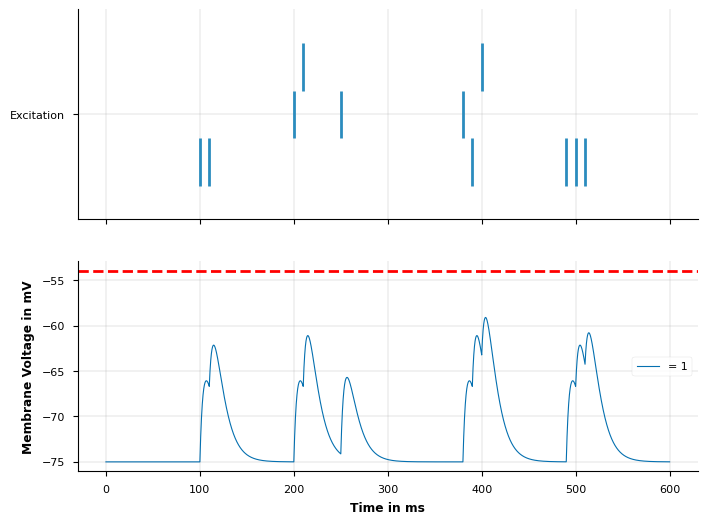

In [48]:
def transform_to_event_input(binned_spikes, bin_size=0.1):
    bin_offset = bin_size/2.
    n_bins = len(binned_spikes)
    bin_times = np.linspace(bin_offset,
                            n_bins*bin_size-(bin_size-bin_offset),
                            n_bins)
    spike_times = binned_spikes * bin_times
    spike_times = spike_times[spike_times != 0]
    return bin_times, spike_times


def create_poisson_process(time_steps, rate,dt):
    ''' this function takes an time_steps (an integer) for the lenght of the process
        the rate in Hz (1/s) of the poisson process
        and dt, the bin size (in ms)'''
    
    rate = rate*1e-3 # rate is usually given in 1/s , we need 1/ms

    x = np.zeros(time_steps)
    x[np.random.rand(time_steps) <= rate*dt] = 1
    
    _, events = transform_to_event_input(x, bin_size=dt)

    return events

def run_and_plot_simulation_for_inputs(time_steps = 10000,
                              g_ampa = 0.05,
                              g_gaba = 0.05,
                              refrac_time = 0,
                              allow_spiking = True,
                              show_plot = True,
                              seed = None,
                              ax = None, ax_2 = None):
    dt = 0.05

    if seed != None:
        np.random.seed(seed)
    
    all_excitatory_inputs = [
        np.array([100,110,390, 490,500,510]),
        np.array([200,250,380]),
        np.array([210,400])
    ]
    
    n_excitatory_inputs = len(all_excitatory_inputs)
    all_inhibitory_inputs = []
    
    neuron = LIFNeuron(g_ampa = g_ampa, 
                       g_gaba = g_gaba,
                       n_gaba_inputs = 0,
                       n_ampa_inputs = n_excitatory_inputs,
                       dt=dt,  
                       refrac_time = refrac_time, 
                       allow_spiking=allow_spiking)
    neuron.run_simulation(time_steps, 
                        ampa_inputs = all_excitatory_inputs,
                       gaba_inputs = all_inhibitory_inputs,
                       )    
    
    if show_plot:
        if ax == None:
            fig, (ax, ax_2) = plt.subplots(2, sharex = True)
    
    
        for ii in range(n_excitatory_inputs):
            ax.eventplot(all_excitatory_inputs[ii], lineoffsets=ii+0.5, color = '#2b8cbe')

        ax.set_yticks([n_excitatory_inputs/2.])
        ax.set_yticklabels(['Excitation'])

        ax_2.plot(neuron.t_list,neuron.v_list,linewidth=0.8, label = '= 1')
        ax_2.set_xlabel('Time in ms')
        ax_2.set_ylabel('Membrane Voltage in mV')
        ax_2.axhline(neuron.v_th, c='r', linestyle='--')
        
        ax_2.legend()
        
    
    
    return neuron, all_excitatory_inputs, all_inhibitory_inputs


neuron, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = 12_000,
                            show_plot = True,
                            allow_spiking = False, 
                            ax = None, ax_2 = None)

In [45]:
from brian2 import *

10.0


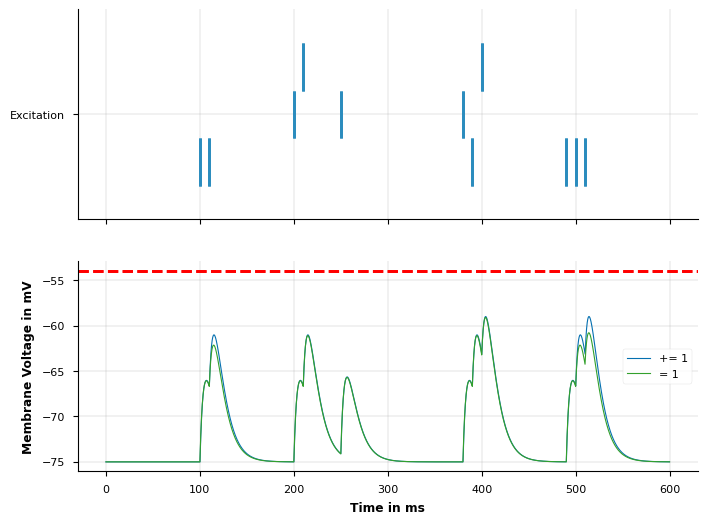

In [49]:
start_scope()
prefs.codegen.target = "numpy"

n_neurons = 100

input_excitation = PoissonGroup(n_neurons, rates=100*Hz)
c_m = 10*nF
r_m = 1*Mohm
tau_m = c_m*r_m
tau_e = 5.26*ms
tau_i = 8*ms
E_i = -80*mV
E_e = 0*mV
E_l = -75*mV
v_threshold = -54 *mV
v_reset = -75*mV
eqs = '''
dv/dt = (E_l - v + r_m*i_i+ r_m*i_e)/tau_m : volt
i_e = g_e * (E_e - v) : amp
i_i = g_i * (E_i - v) : amp
dg_e/dt = -g_e / tau_e : siemens
dg_i/dt = -g_i / tau_i : siemens
'''

print (tau_m/ms)

neuron = NeuronGroup(1, eqs, threshold='v>v_threshold', reset='v=v_reset', method='exponential_euler')
neuron.v = -75*mV

all_excitatory_inputs = [
    np.array([100,110,390, 490,500,510]),
    np.array([200,250,380]),
    np.array([210,400])
]

n_excitatory_inputs = len(all_excitatory_inputs)

indices = []
times = np.array([])
for ii, inputs in enumerate(all_excitatory_inputs):
    indices += [ii for jj in range(len(inputs))]
    times = np.hstack([times, inputs])

input_spikes = SpikeGeneratorGroup(3, np.asarray(indices), times*ms)

input_synapses = Synapses(input_spikes,neuron, 'w : siemens', on_pre = 'g_e += w', name = 'excitatory_connections')
input_synapses.connect()
input_synapses.w = 500*nS

M = StateMonitor(neuron, 'v', record=True)

run(600*ms)

fig, (ax, ax_2) = plt.subplots(2, sharex = True)
    
    
for ii in range(n_excitatory_inputs):
    ax.eventplot(all_excitatory_inputs[ii], lineoffsets=ii+0.5, color = '#2b8cbe')

ax.set_yticks([n_excitatory_inputs/2.])
ax.set_yticklabels(['Excitation'])

ax_2.plot(M.t/ms, M.v[0]/mV,linewidth=0.8, label = '+= 1')
ax_2.set_xlabel('Time in ms')
ax_2.set_ylabel('Membrane Voltage in mV')
ax_2.axhline(v_threshold/mV, c='r', linestyle='--')


neuron, all_excitatory_inputs, all_inhibitory_inputs = run_and_plot_simulation_for_inputs(
                              time_steps = 12_000,
                            show_plot = True,
                            allow_spiking = False, 
                            ax = ax, ax_2 = ax_2)

ax_2.legend()